In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy
import scipy
import pandas
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import subprocess
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
import hpc_lib
#
# TODO: phase out unreferenced hpc_lib calls...
#import hpc_lib
#import hpc_reports
#
def running_mean(X,n=10):
    return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
#

## Realtime Monitoring tools

### General objective:
- Some tools to do realtime monitoring of SERC usage
- Nominally more versatile than that; could be SERC, users, groups, etc. 
- Design some metrics to indicate excessive usage; send alerts; make pretty graphs.

Possible starting query:
        squeue -p serc --Format=jobid,jobarrayid,partition,name,userid,timeused,timeleft,numnodes,nodelist,numcpus,state

Use this to identify:
- An individual user or group using >1/3 of the cluster for >1 hour (or so)
- Generally, times of high impact (lots of running and pending jobs)

Note that it is not trivial to estimate this. Loads of jobs pending is not significant, for example, if they have short runtimes. What we really want to catch is a scenario where a job array (or similar) picks up a bunch of idle resources (eg, overnight when usage is lower) for >24 hour runtime jobs.


In [3]:
class SPART_obj(object):
    # Python handler for SPART,or partition summary info kabob.
    # SPART looks like a third party tool to provide partition type info.
    # https://github.com/mercanca/spart
    #
    def __init__(self, options='gmft', format_fields_dict=None, verbose=False):
        '''
        # @options: spart options (see docs or man or whatever...). Can be list-like or string.
        # internally, this will get parsed into a list of unique letter values and passed like, '-g -m -f'
        #
        '''
        #
        options = [ (s.decode() if hasattr(s, 'decode') else s) for s in options]
        spart_str = 'spart {}'.format(' '.join(f'-{s}' for s in options) )
        self.SP = self.get_spart_data(spart_str=spart_str)
        #
        self.__dict__.update({ky:vl for ky,vl in locals().items() if not ky in ('self', '__class__')})

    def get_spart_data(self, spart_str=None, verbose=False):
        spart_str = spart_str or self.spart_str
        #
        squeue_output = subprocess.run(spart_str.split(), stdout=subprocess.PIPE).stdout.decode().split('\n')
        squeue_output = [rw.replace('|', '') for rw in squeue_output]
        #print('** DEBUG: ', squeue_output)
        #
        # the output is a bit of a mess, but we can put it together...
        for k,rw in enumerate(squeue_output):
            if rw.lstrip().startswith('QUEUE'):
                cols = rw.split()
                cols = [f'{c1}{c2}' for c1,c2 in zip(cols, squeue_output[k+1].split()) ]
                #
                break
            #
        data = [rw.split() for rw in squeue_output[k+2:] if not len(rw)==0]
        
        #return [cols] + data
        return pandas.DataFrame(data=data, columns=cols, index=[rw[0] for rw in data])
    #
    @property
    def cols(self):
        return self.SP.columns
    #
    def get_total_cpus(self, partitions='normal'):
        if isinstance(partitions, str):
            partitions = partitions.split(',')
        #
        return numpy.sum(self.SP['TOTALCORES'][partitions].to_numpy().astype(float))
    def get_total_gpus(self, partitions='gpu', verbose=False):
        # gpus in GRES, like: gpu:4(S:0)(2),gpu:8(S:0-3)(6)
        if isinstance(partitions, str):
            partitions = partitions.split(',')
        #
        gres = self.SP['GRES(NODE-COUNT)'][partitions].to_list()
        #
        # flatten and split by 'gpu:' entries:
        gres = [s for ss in gres for s in ss.split(',') if s.startswith('gpu')]
        #
        # TODO: The right way to do this is with regular expressions. but I hate regular expressions,
        #. so for now, we'll just hack it.
        #expr='gpu:\d+(S:.*)(\d+)'
        ngpus = 0
        for k,s in enumerate(gres):
            if verbose:
                print('** * DEBUG: gres: ', gres)
            n_gpu = s[4:s.index('(')]
            #print(f'** {s}, {n_gpu}')
            #
            if '(S:' in s:
                N_server = s[s.index('(',s.index('(')+1)+1:s.index(')', s.index(')')+1  ) ]
            else:
                try:
                    N_server = s[s.index('(')+1 : s.index(')')]
                except:
                    N_server = 1
            #
            #print(f'** [{k}] : {s} :: {n_gpu} :: {N_server} ')
            #
            ngpus += int(n_gpu)*int(N_server)
            
        #
        return ngpus
 
        
SP = hpc_lib.SPART_obj()
#SP = SPART_obj(options=['g', 'm', 'f', 't', 'i'])
#
print('** ', SP.options)
        

**  ['g', 'm', 'f', 't']


In [4]:
GREs = SP.get_total_gpus(partitions='serc,gpu')

In [5]:
#print('** ', SP.SP)
gres = SP.SP['GRES(NODE-COUNT)'][['serc', 'gpu']].to_list()
gres = [s for ss in gres for s in ss.split(',') if s.startswith('gpu')]
#
# def gres_to_ngpus(gres_str):
#     s = gres_str
#     n_gpu    = s[4:s.index('(')]
#     n_server = s[s.index('(',s.index('(')+1)+1:s.index(')', s.index(')')+1  ) ]
#     #
#     return int(n_gpu)*int(n_server)

# print('gres_to_ngpus(gpu:4(S:0-1))', gres_to_ngpus('gpu:4(S:0-1)'))

In [6]:
    
def sinfo_ncpus_ngpus(partition='serc', as_tuple=False):
    '''
    # get number of cpu CPUs and gpu CPUs and GPUs from sinfo query. Return is like (?)
    #. {'cpu':N_cpu, 'gpu':N_gpu, 'gpu_cpu': N_gpu_cpu)}
    # what is the best output? {'gpu':{'gpu':n, 'cpu',m}} ?{'cpu', 'gpu', 'gpu_cpu'?}
    '''
    #
    sinfo_str = f'sinfo -p {partition} -N --Format=cpus,gres'
    cpus_gres = squeue_output = subprocess.run(sinfo_str.split(),
                                               stdout=subprocess.PIPE).stdout.decode().split('\n')
    #
    cpus_gpus = {'cpu': 0, 'gpu': 0, 'gpu_cpu': 0}
    #
    for k,rw in enumerate(cpus_gres[1:]):
        #
        if len(rw)== 0:
            continue
        cpu,gre = rw.split()
        #
        n_gpu = None
        if 'gpu:' in gre:
            k0 = gre.index('gpu:')
            n_gpu = int(gre[k0+4:gre.index('(',k0)])
            #
            cpus_gpus['gpu'] += n_gpu
            cpus_gpus['gpu_cpu'] += int(cpu)
        else:
            cpus_gpus['cpu'] += int(cpu)
        #
    if as_tuple:
        return (cpus_gpus[ky] for ky in ('cpu', 'gpu', 'gpu_cpu'))
    else:
        return cpus_gpus
    
#sdp = SP.get_spart_data()
# print('** ', sp[0])
# print('\n\n** ', sp[1])
# ix = [rw[0] for rw in sp[1:]]
# print('** ix: ', ix)
#sdp = pandas.DataFrame(data=sp[1:], columns=sp[0], index=[rw[0] for rw in sp[1:]])
# print('** ', numpy.shape(sp))
# for rw in sp:
#     print('** ', rw)

# print('** ', SP.get_total_cpus(partitions=['serc','normal']))
# print('** ', SP.get_total_cpus(partitions=['serc','normal','hns']))
# print('** ', SP.get_total_gpus(partitions='serc,gpu'))
#
GREs = SP.get_total_gpus(partitions='serc,gpu')
#
print('** ', GREs)
#
c_g = hpc_lib.sinfo_ncpus_ngpus()
print('c_g: ', c_g)
my_partition='serc, normal'
print(f'** {my_partition}  {hpc_lib.sinfo_ncpus_ngpus(partition=my_partition, as_tuple=True)}' )


**  160
c_g:  {'cpu': 4640, 'gpu': 56, 'gpu_cpu': 816}
** serc, normal  (8672, 56, 816)


In [7]:
# format_fields = {'jobid':str, 'jobarrayid':str, 'partition':str, 'name':str, 'username':str, 'timeused':str, 
#                     'timeleft':str, 'numnodes':int, 'numcpus':int, 'numtasks':int, 'nodelist':str, 'state':str}

# class SQUEUE_obj(object):
#     # SQUEUE manager, principally to estimate realtime SLURM activity. Like SACCT_obj, but
#     #  uses squeue. We *could* use SACCT_obj and just limit to --State=running,pending
#     #. but it seems that sacct is much slower than squeue.
#     #
#     def __init__(self, partition='serc', format_fields_dict=None, squeue_prams=None, verbose=False):
#         #
#         # @squeue_prams: additional or replacement fields for squeue_fields variable, eg parameters
#         #. to pass to squeue. Presently, --Format and --partition are specified. some options might also
#         #. be allowed as regular inputs. Probably .update(squeue_prams) will be the last thing done, so 
#         #  will overried other inputs.
#         #
#         # TODO: add ***kwargs and handle syantax like SQU_{something} to add to squeue_fields, etc.
        
#         if format_fields_dict is None:
#             format_fields_dict = hpc_lib.default_SLURM_types_dict
#         #
#         squeue_fields = {'--Format': ['jobid', 'jobarrayid', 'partition', 'name', 'username', 'timeused', 
#                                       'timeleft', 'numnodes', 'numcpus', 'numtasks', 'state', 'nodelist'],
#                       '--partition': [partition]
#                       }
#         if isinstance(squeue_prams, dict):
#             squeue_fields.update(squeue_prams)
#         #
#         squeue_delim=';'
#         sinfo_str = 'squeue '
#         for ky,vl in squeue_fields.items():
#             delim=' '
#             if ky.startswith('--'):
#                 # long format
#                 delim='='
#             #
#             sinfo_str = '{} {}{}{}'.format(sinfo_str, ky, delim, f':{squeue_delim},'.join(vl))
#         #
#         if verbose:
#             print('*** sinfo_str: {}'.format(sinfo_str))
#             print('*** sinfo_ary: {}'.format(sinfo_str.split()))
#         #
#         # TODO:
#         # port some of these bits to class-scope function calls, for class portability
#         #
#         self.__dict__.update({ky:vl for ky,vl in locals().items() if not ky in ('self', '__class__')})
#         self.set_squeue_data()
#     #
#     def set_squeue_data(self):
#         self.squeue_data = self.get_squeue_data()
#         self.dtype       = self.squeue_data.dtype
#     #
#     def __getitem__(self, *args, **kwargs):
#         return self.squeue_data.__getitem__(*args, **kwargs)
#     def __setitem__(self, *args, kwargs):
#         return self.squeue_data.__setitem__
#     #
#     def get_squeue_data(self, sinfo_str=None, squeue_delim=None, verbose=False):
#         sinfo_str = sinfo_str or self.sinfo_str
#         squeue_delim = squeue_delim or self.squeue_delim
#         #
#         print(f'** squeue: {sinfo_str}' )
#         squeue_output = subprocess.run(sinfo_str.split(), stdout=subprocess.PIPE).stdout.decode().split('\n')
#         #cols = squeue_output[0].split(squeue_delim)
#         #
#         # there is a smarter way to do this, eg:
#         cols = squeue_output[0].split(squeue_delim)
#         for k,cl in enumerate(cols):
#             cl_0 = cl
#             k_rep = 0
#             while cols[k] in cols[0:k]:
#                 cols[k] = f'{cl}_{k_rep}'
#         if verbose:
#             print('** cols: ', cols)
#         #
# #         # DEBUG:
# #         for k,rw in enumerate(squeue_output):
# #             #print(f'** rw[{k}]: {rw.split(squeue_delim)}')
# #             print(f'** rw[{k}]: {rw}')
#         #
#         return pandas.DataFrame(data=[[self.format_fields_dict.get(cl.lower(),str)(x) 
#                                   for x, cl in zip(rw.split(squeue_delim),
#                                 self.squeue_fields['--Format']) ]
#                                  for rw in squeue_output[1:] if not len(rw.strip()) == 0],
#                                    columns=cols).to_records()
#     #
#     def get_active_jobs(self, *args, **kwargs):
#         # print('** DEBUG: args: {}'.format(args))
#         if len(args)>=6:
#             args[5]
#         kwargs['do_jobs'] = True
#         return get_active_cpus(*args, **kwargs)
#     #
#     def get_active_cpus(self, state='running,pending', do_refresh=False, state_data=None, ncpus=None, do_cpus=True, do_jobs=False):
#         if do_refresh:
#             self.set_squeue_data()
#         #
#         if isinstance(state,bytes):
#             state=state.decode()
#         if isinstance(state,str):
#             state=state.split(',')
#         #
#         for k,s in enumerate(state):
#             state[k] = s.upper()
#         #
#         if state_data is None:
#             state_data = self['STATE']
#         if ncpus is None:
#             ncpus = self['CPUS']
#         #
#         ix = numpy.isin(state_data, state)
#         n_jobs, n_cpus = numpy.sum(ix), numpy.sum(ncpus[ix])
#         #
#         if do_cpus and do_jobs:
#             return (n_jobs, n_cpus)
#         if do_cpus:
#             return n_cpus
#         if do_jobs:
#             return n_jobs
#     #
#     def simple_wait_estimate(self, ncpus=1, max_cpus=4600, do_refresh=False):
#         # TODO: figure out the right way(s) to get max_cpus from system.
#         active_cpus = self.get_active_cpus(state='running,pending', do_refresh=do_refresh)
#         avail_cpus = max_cpus - active_cpus
#         #
#         if ncpus <= avail_cpus:
#             return 0
#         #
#         cpus_needed = ncpus - avail_cpus
#         #
#         # now, spin down self['TIME_LEFT'] until we have enough CPUs to do our job. that TIME_LEFT is
#         #. when our job should be available.
#         #
#         return None
#     #
#     def report_user_cpu_job_pies(self, state='RUNNING,PENDING', cpus_total=5456, add_idle=True, ax1=None, ax2=None):
#         #
#         # TODO: use scontrol or sinfo to get an automagical cpus_total count.
#         #
#         user_data = self.get_user_cpu_job_data(state=state, add_idle=add_idle)
#         #
#         if ax1 is None or ax2 is None:
#             fg = plt.figure(figsize=(12,8))
#             ax1 = fg.add_subplot(1,2,1)
#             ax2 = fg.add_subplot(1,2,2)
#         #
#         ax1.pie(user_data['jobs'],  labels=user_data['user'], autopct='%.1f')
#         ax2.pie(user_data['ncpus'], labels=user_data['user'], autopct='%.1f')
#         #
#         ax1.set_title('Jobs', size=16)
#         ax2.set_title('CPUs', size=16)
#         #
#         #ax1.legend(loc=0)
        
#         return user_data
#     #
#     def get_user_cpu_job_data(self, state='RUNNING,PENDING', cpus_total=5456, add_idle=True):
#         #partition = partition or self.partition
#         if isinstance(state,bytes):
#             state=state.decode()
#         if isinstance(state,str):
#             state = state.split(',')
#         sq = self[numpy.isin(self['STATE'].astype(type(state)), state)]
#         print('*** ', self['STATE'].astype(type(state))[0:10], '*** ', state)
#         #
#         users = list([u for u in set(sq['USER']) if not u is None])
#         #if add_idle:
#         #    users += ['idle']
#         print('** users: ', users)
#         #
#         out_data = numpy.empty(shape=(len(users) + int(add_idle),), 
#                     dtype=[('user', f'U{max([len(s) for s in users])}'), ('jobs', '<f8'), ('ncpus', '<f8')])
        
#         #out_data['jobs'] = numpy.zeros(len(users))
#         #out_data['ncpus'] = numpy.zeros(len(users))
#         #
#         # NOTE: there is also a (faster) syntax to broadcast this, then sum on an axis.
#         jobs  = [numpy.sum( (self['USER']==u) ) for u in users]
#         ncpus = [numpy.sum( self['CPUS'][(self['USER']==u)] ) for u in users]
#         #
#         if add_idle:
#             jobs += [0]
#             ncpus += [cpus_total-numpy.sum(ncpus)]
#             users += ['idle']
#         #
#         out_data['user']  = users
#         out_data['jobs']  = jobs
#         out_data['ncpus'] = ncpus
#         #
#         return out_data
        
        
          
        
SQ = hpc_lib.SQUEUE_obj()      
#

** squeue: squeue  --Format=jobid:;,jobarrayid:;,partition:;,name:;,username:;,timeused:;,timeleft:;,numnodes:;,numcpus:;,numtasks:;,state:;,nodelist --partition=serc


In [8]:
print('** ', 6*128 + 8*128 + 14*24 + 104*32)
print('*** ', SQ.sinfo_str)
print('** ', SQ.get_active_cpus(state='running,pending'))
#


**  5456
***  squeue  --Format=jobid:;,jobarrayid:;,partition:;,name:;,username:;,timeused:;,timeleft:;,numnodes:;,numcpus:;,numtasks:;,state:;,nodelist --partition=serc
**  3051


***  ['PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING'
 'RUNNING' 'RUNNING' 'RUNNING'] ***  ['RUNNING', 'PENDING']
** users:  ['juwoo', 'axelwang', 'aguilars', 'anovosel', 'liviafp', 'lauraman', 'riesr', 'malenda', 'rsalcedo', 'juliojof', 'gegewen', 'cbaden', 'haofu', 'cooper96', 'ag4680', 'robcking', 'myoder96', 'yifu', 'chrisauc', 'pjwomble', 'mliu9', 'alpatil', 'hilley']
** 
** sunet, nodes, cpus
**  ('juwoo', 2., 2.)
**  ('axelwang', 1., 560.)
**  ('aguilars', 11., 472.)
**  ('anovosel', 1., 7.)
**  ('liviafp', 3., 6.)
**  ('lauraman', 1., 32.)
**  ('riesr', 1., 24.)
**  ('malenda', 384., 765.)
**  ('rsalcedo', 1., 16.)
**  ('juliojof', 1., 8.)
**  ('gegewen', 1., 16.)
**  ('cbaden', 1., 2.)
**  ('haofu', 2., 240.)
**  ('cooper96', 1., 1.)
**  ('ag4680', 1., 32.)
**  ('robcking', 1., 32.)
**  ('myoder96', 1., 4.)
**  ('yifu', 1., 5.)
**  ('chrisauc', 2., 251.)
**  ('pjwomble', 53., 55.)
**  ('mliu9', 1., 8.)
**  ('alpatil', 2., 512.)
**  ('hilley', 1., 1.)
**  

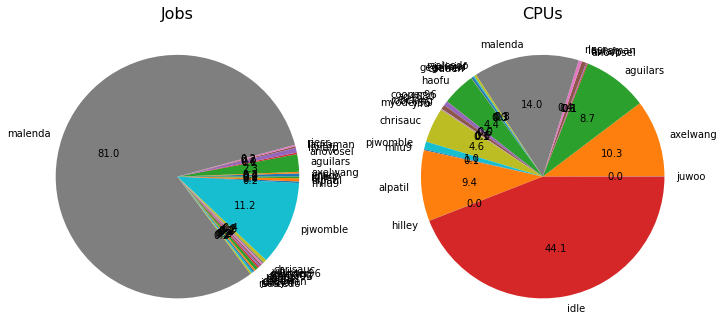

In [9]:
# users = list([u for u in set(SQ['USER']) if not u is None])
# print('** ', users)
#         #
# out_data = numpy.empty(shape=(len(users),), 
#             dtype=[('user', f'U{max([len(s) for s in users])}'), ('jobs', '<f8'), ('ncpus', '<f8')])
# out_data['user'] = users
# out_data['jobs'] = numpy.zeros(len(users))
# out_data['ncpus'] = numpy.zeros(len(users))
# #
# print('** ', out_data)

user_pie = SQ.report_user_cpu_job_pies()
print('** ')
print('** sunet, nodes, cpus')
for rw in user_pie:
    print('** ', rw)

In [10]:
print('** sum, ', numpy.sum(user_pie['ncpus']))

** sum,  5456.0


In [11]:
#SQ.set_squeue_data()
print('** users: ', set(SQ['USER']))
#
print('** ', SQ['TIME'][0:20])
print('** ', SQ['TIME_LEFT'][0:20])
print('** ', hpc_lib.elapsed_time_2_day('13:14:10'))

** users:  {'myoder96', 'axelwang', 'pjwomble', 'aguilars', 'cbaden', 'haofu', 'cooper96', 'mhan8', 'rsalcedo', 'anovosel', 'alpatil', 'chrisauc', 'earlew', 'ag4680', 'juwoo'}
**  [0.         0.         0.51287037 0.81940972 0.93872685 0.16710648
 0.40050926 2.32519676 0.08488426 0.08488426 0.08488426 0.04064815
 0.46252315 0.46293981 0.08488426 0.45984954 0.00862269 1.61873843
 0.74777778 0.02143519]
**  [3.47222222e-03 1.00000000e+00 3.48712963e+00 1.80590278e-01
 6.86273148e-01 6.79122685e+00 2.24490741e-01 3.09146991e+00
 6.74844907e+00 6.79011574e+00 6.91511574e+00 1.26018519e-01
 4.95414352e+00 4.95372685e+00 6.79011574e+00 6.41515046e+00
 1.58043981e-01 3.81261574e-01 6.21055556e+00 3.53564815e-01]
**  0.5515046296296297


In [12]:
print('** ', SQ.format_fields_dict['time_left'])
print('** ', SQ.dtype)
SQ.get_active_cpus(do_jobs=True, do_cpus=True)

KeyError: 'time_left'

In [ ]:
print('** ', SQ['STATE'][0:20])
ix = [s in ['RUNNING'] for s in SQ['STATE'] ]

#print('** ', ix)
